In [1]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight



In [2]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')

In [3]:
def import_data(which_path=2):
    if which_path==1:
        images_directory = path/'train_images'
    else: 
        images_directory = path/'train_images2'
    cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
    cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)
    return (cb_training, cb_validation)


def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

# Try different Dense Layer on VGG 

In [5]:
filename = 'vgg19-cb-2.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)

base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model2.layers:
    layer.trainable = False

x2 = base_model2.output
x2 = Flatten()(x2)

x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(.5)(x2)
x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(.5)(x2)
x2 = Dense(100, activation='relu')(x2)
x2 = Dropout(.5)(x2)


predictions2 = Dense(1, activation='sigmoid')(x2)
optimizer = Adam(learning_rate=0.00001)

model2 =  Model(inputs=base_model2.input, outputs=predictions2)
model2.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)

history2 = model2.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10


2022-03-22 17:51:54.554532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


750/750 [==============================] - 690s 918ms/step - loss: 3.8134 - tp: 3054.0000 - fp: 8285.0000 - tn: 10087.0000 - fn: 2574.0000 - accuracy: 0.5475 - precision: 0.2693 - recall: 0.5426 - auc: 0.5589 - prc: 0.2664 - val_loss: 0.6783 - val_tp: 1135.0000 - val_fp: 1649.0000 - val_tn: 2952.0000 - val_fn: 264.0000 - val_accuracy: 0.6812 - val_precision: 0.4077 - val_recall: 0.8113 - val_auc: 0.7959 - val_prc: 0.5061

Epoch 00001: val_accuracy improved from -inf to 0.68117, saving model to vgg19-cb-2.h5
Epoch 2/10
750/750 [==============================] - 1039s 1s/step - loss: 1.4842 - tp: 3149.0000 - fp: 7249.0000 - tn: 11123.0000 - fn: 2479.0000 - accuracy: 0.5947 - precision: 0.3028 - recall: 0.5595 - auc: 0.6160 - prc: 0.2981 - val_loss: 0.5156 - val_tp: 1053.0000 - val_fp: 1276.0000 - val_tn: 3325.0000 - val_fn: 346.0000 - val_accuracy: 0.7297 - val_precision: 0.4521 - val_recall: 0.7527 - val_auc: 0.7979 - val_prc: 0.4861

Epoch 00002: val_accuracy improved from 0.68117 to 0

In [7]:
cb_training, cb_validation  = import_data()

model2.evaluate(cb_validation, verbose=1)

Found 29195 files belonging to 2 classes.
Using 23356 files for training.
Found 29195 files belonging to 2 classes.
Using 5839 files for validation.
183/183 [==============================] - 235s 1s/step - loss: 0.4898 - tp: 993.0000 - fp: 1393.0000 - tn: 3214.0000 - fn: 239.0000 - accuracy: 0.7205 - precision: 0.4162 - recall: 0.8060 - auc: 0.8030 - prc: 0.4360


[0.4898050129413605,
 993.0,
 1393.0,
 3214.0,
 239.0,
 0.720500111579895,
 0.4161776900291443,
 0.8060064911842346,
 0.8030214905738831,
 0.43602195382118225]

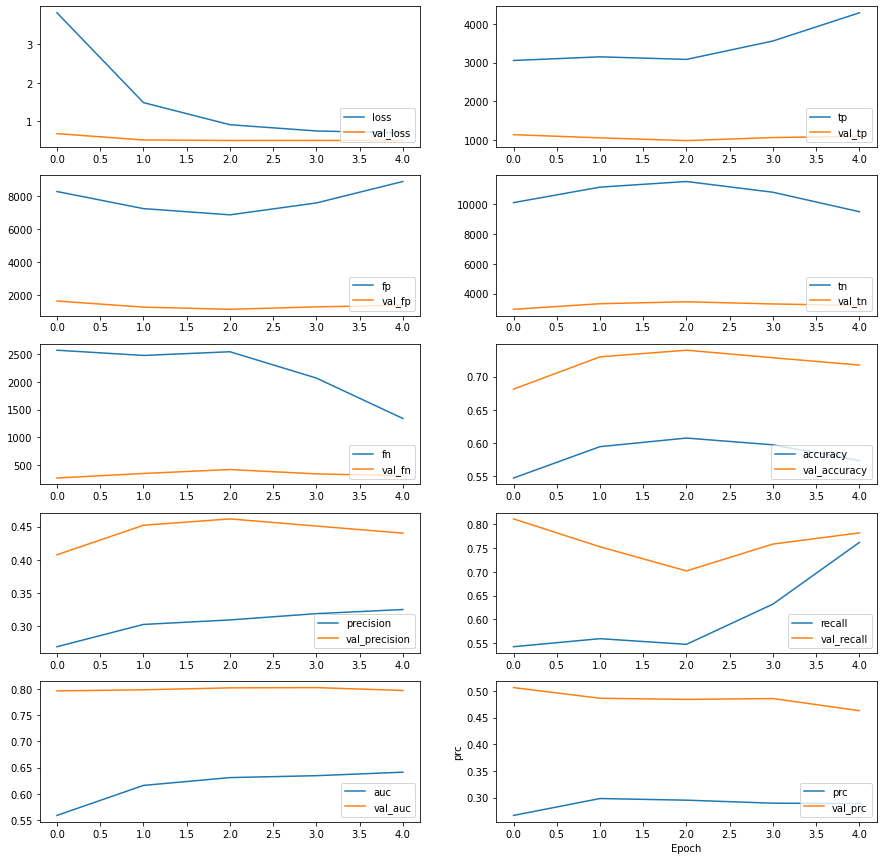

In [8]:
hist = history2.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key], label=key)
        ax.plot(hist[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

# Analysis 
Lowest validation scores out of all of our models currently, including the homegrown CNN. 
Abandoning